In [21]:
#Loading packages and functions for Manuscript figures

import pandas as pd
import pyBigWig 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
# data/chip contains chip-seq data

# Methylation Bigwig directories:
# data/meth/t contains T-cell data
# data/meth/s contains epidermis (skin) data 
# data/meth/l contains mouse liver data


#plotting total methylation per sample 
def pwg(cells,path,x,chrs=22,labels=[],color=[],w=.9,ylabel='DNAm',figure='f'): 
    if len(labels)==0: labels=cells
    bs=[]
    for cell in cells:
        print(cell,end=',')
        bw=pyBigWig.open(path+cell+'.bw')
        bsc=[]
        for ch in range(1,chrs+1):
            bsc.append(bw.stats('chr'+str(ch),0,-1)[0])
        bs.append(bsc)
    bs=pd.DataFrame(bs)
    pl=pd.DataFrame(bs.mean(1))
    pl[x]=cells
    fig, ax = plt.subplots(figsize=(w,2));
    ax=sns.barplot(data=pl,x=x,y=0);
    if len(color)>0:
        ax=sns.barplot(data=pl,x=x,y=0,palette=color);        
    ax.set(ylabel=ylabel,title='All CpGs');
    ax.set_xticklabels(labels);
    plt.xticks(rotation=90,fontsize=8); 
    fig.savefig('figures/'+figure+'.eps', dpi=600,bbox_inches='tight',format='eps')
    return bs

#Create dataframe with rolling average based on number of CpGs per LMR
def prc(dft):
    c0=cells[0]
    l=dft.apply(lambda x:int(x['d'])*[x[c0]],axis=1)
    l=[item for sublist in l for item in sublist]
    df=pd.DataFrame(l)
    df.columns=[c0]
    for cell in cells[1:]:
        l=dft.apply(lambda x:int(x['d'])*[x[cell]],axis=1)
        l=[item for sublist in l for item in sublist]
        df[cell]=l
    return df

#PRC2 AgeIndex plot - plotting percentage methylation (rolling average) against LMRs sorted by PRC2 binding 
def pprc(tp,color=[],title='DNAm at LMRs',r=10**5,w=3,ylabel='DNAm',figure='f'):
    if len(color)>0:
        ax=tp.rolling(r).mean().dropna().plot(figsize=(w,2),color=color)    
    else:
        ax=tp.rolling(r).mean().dropna().plot(figsize=(w,2))    
    ax.get_legend().remove()
    ax.set_xticks([])
    ax.set_xlabel('LMRs ranked by PRC2 binding', fontsize=10)
    ax.set(ylabel=ylabel,title=title);
    ax.get_figure().savefig('figures/'+figure+'.eps', dpi=600,bbox_inches='tight',format='eps')

#Zoomed in plot of right hand side of PRC2 AgeIndex Plot
def pprch(tp,n,m,color=None,labels=[],legend_title='years',figure='f',title=''):
    dg=tp.tail(round(10**n)).rolling(round(10**m)).mean().dropna()
    ax=dg.plot(figsize=(1.2,2),color=color)
    if len(labels)==0: 
        labels=tp.columns
        handles, labels = ax.get_legend_handles_labels()    
        ax.legend(handles[::-1], labels[::-1],title=legend_title,loc='center left', bbox_to_anchor=(1, 0.5))    
    else:
        handles, l = ax.get_legend_handles_labels()    
        ax.legend([handles[-1],handles[0]], [labels[-1],labels[0]],title=legend_title,loc='center left', bbox_to_anchor=(1, 0.5))    
    ax.set_xticks([])
    ax.set_xlabel('PRC2 binding', fontsize=10)  
    ax.set_title('DNAm at High-PRC2 LMRs')    
    ax.get_figure().savefig('figures/'+figure+'.eps', dpi=600,bbox_inches='tight',format='eps')
    return dg

#Further zoom of right hand side of PRC2 AgeIndex Plot
def pprchz(tp,n,m,color=None,labels=[],legend_title='years',figure='f',title=''):
    dg=tp.tail(round(9**n)).rolling(round(10**m)).mean().dropna()
    ax=dg.plot(figsize=(1.2,2),color=color)
    if len(labels)==0: 
        labels=tp.columns
        handles, labels = ax.get_legend_handles_labels()    
        ax.legend(handles[::-1], labels[::-1],title=legend_title,loc='center left', bbox_to_anchor=(1, 0.5))    
    else:
        handles, l = ax.get_legend_handles_labels()    
        ax.legend([handles[-1],handles[0]], [labels[-1],labels[0]],title=legend_title,loc='center left', bbox_to_anchor=(1, 0.5))    
    ax.set_xticks([])
    ax.set_xlabel('PRC2 binding', fontsize=10)  
    ax.set_title('DNAm at High-PRC2 LMRs')    
    ax.get_figure().savefig('figures/'+figure+'.eps', dpi=600,bbox_inches='tight',format='eps')
    return dg


#Plot methylation of high PRC2 binding LMRs per chromosome
def chs(t,cells,n,ages=[],color=[],figure='f'):
    tt=t.tail(10**n)[['ch']+cells]
    pl=tt.melt('ch')
    pl['chn']=pl['ch'].str[3:].astype(int)
    if len(ages)>0:
        pl['age']=pl['variable']#.astype(int)
    else:
        pl['age']=pl['variable'].astype(int)
    pl=pl.sort_values(['chn','age']).drop('chn',axis=1)
    fig, ax = plt.subplots(figsize=(7,2));
    ax=sns.barplot(data=pl,x='ch',y='value',hue='variable',ci=0);
    if len(color)>0:
        ax=sns.barplot(data=pl,x='ch',y='value',hue='variable',ci=0,palette=color);
    ax.legend_.remove();
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
    ax.set(xlabel = "", ylabel = "DNAm",title='DNAm at High-PRC2 LMRs (by Chrs)');  
    fig.savefig('figures/'+figure+'.eps', dpi=600,bbox_inches='tight',format='eps')
    
#Function to plot high PRC2 LMR methylation per sample
def hprc(cohort,colors):    
    fig, ax = plt.subplots(figsize=(len(colors)*.1,2));
    sns.barplot(data=c[cells].tail(1000),palette=colors, ax=ax)
    ax.set(ylabel='DNAm',title='High-PRC2 LMRs',xlabel='samples');
    ax.set_xticklabels('');
    #plt.xticks(rotation=90,fontsize=8); 
    fig.savefig('figures/'+'Fig5_'+cohort+'_high_prc2.eps', dpi=600,bbox_inches='tight',format='eps')

0,18,25,82,86,103,

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


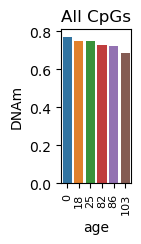

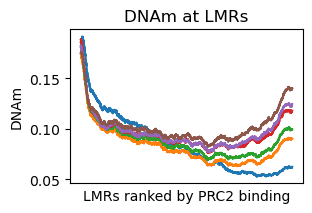

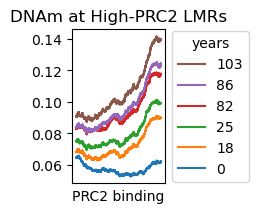

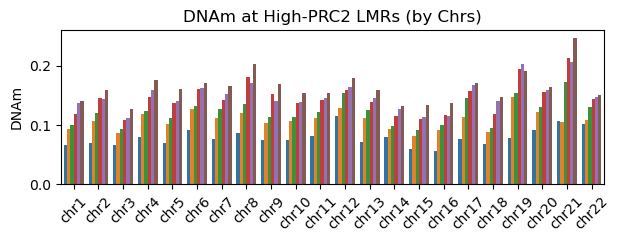

In [31]:
#Fig 2.a - Generating T-cell LMR plots (GSE79798 & GSE31263)
cells=['0','18','25','82','86','103']
path='data/meth/t/'
pwg(cells,path,'age',figure='Fig2_a_t4_wg');
t=pd.read_csv('results/t.csv')
tp=prc(t)
pprc(tp,figure='Fig2_a_t4_lmr')
pprch(tp,6,5,figure='Fig2_a_t4_prc')
chs(t,cells,3,figure='Fig2_b')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


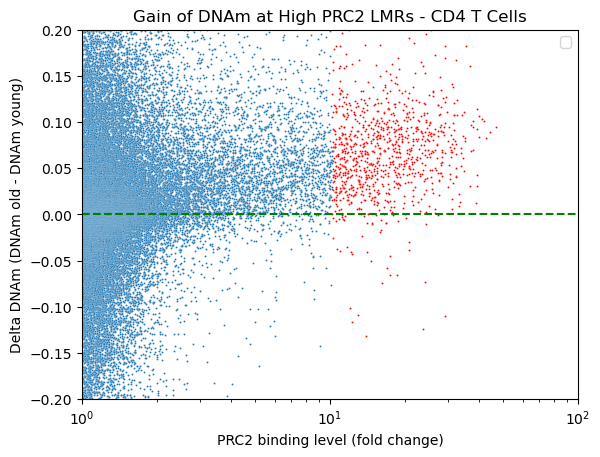

In [32]:
#Fig 1.c - Gain of methylation between young and old CD4 T-cells (GSE79798 & GSE31263)
figure='Fig1_c_t'
t['up']=t['103']-t['0']
pl=t[['up','pr']]
pt=pl.tail(1000)
pr=pl.head(len(t)-1000)
ax=sns.scatterplot(data=pt,y='up',x='pr',s=2,color='r')
ax=sns.scatterplot(data=pr,y='up',x='pr',s=2)
ax.set(xscale='log',xlim=[1,100],ylim=[-.2,.2],
       ylabel='Delta DNAm (DNAm old - DNAm young)',
       xlabel='PRC2 binding level (fold change)',
      title='Gain of DNAm at High PRC2 LMRs - CD4 T Cells');
plt.axhline(y=0, xmin=0,xmax=1,color='g',linestyle='--')
ax.get_figure().savefig('figures/'+figure+'_ezfb.eps', dpi=600,bbox_inches='tight',format='eps')
plt.legend()
plt.show()

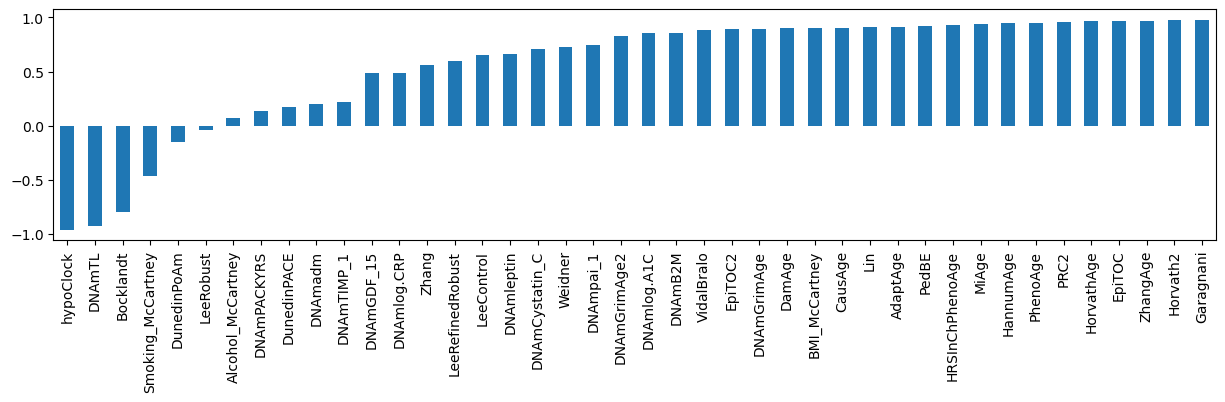

In [33]:
#S.Fig 2 - plotting correlation of various published epigenetic clocks applied to WGBS T-cell data
#Getting correlation of methylation against age for top 1000 PRC2 binding LMRs in t-cell

cor=pd.DataFrame(t[cells].tail(1000).mean(),columns=['m'])
cor['age']=[int(cell) for cell in cells]
cor.corrwith(cor['age']).m.round(2)
r=pd.read_csv('SupplementFig2/t_clocks.csv',index_col=0)
r=r.T
r['25']=r[['25_1','25_2']].mean(1)
r['0']=r['Human_CD4T-Newborn']
r['103']=r['Human_CD4T-103yr']
r=r[cells].T
r['age']=[int(cell) for cell in cells]
r['PRC2']=cor['m']
pl=r.corrwith(r['age']).sort_values().round(2).drop('age')
ax=pl.plot(kind='bar',figsize=(15,3));
ax.get_figure().savefig('figures/FigS2_t.eps', dpi=600,bbox_inches='tight',format='eps')

18,23,25,74,75,83,

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


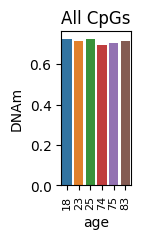

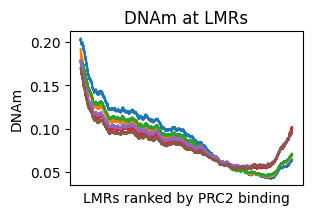

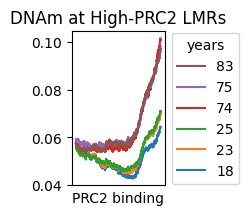

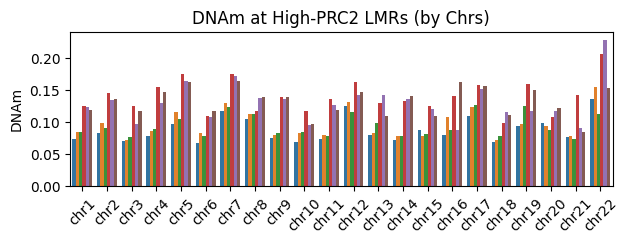

In [186]:
# Fig. 2a and b - Generating epidermis LMR plots (GSE52972)

cells=['18','23','25','74','75','83']
path='data/meth/s/'
pl=pwg(cells,path,'age',figure='Fig2_a_epi_wg')
s=pd.read_csv('results/s.csv')
sp=prc(s)
pprc(sp,figure='Fig2_a_epi_lmr')
pprch(sp,6,5,figure='Fig2_a_epi_prc')
ax=chs(s,cells,3)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


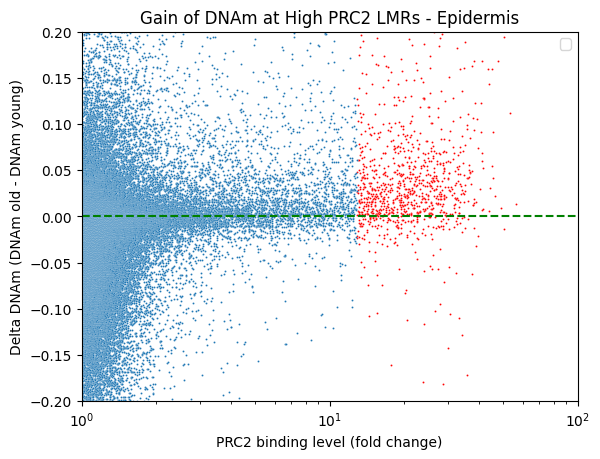

In [187]:
#Fig 1.c - Gain of methylation between young and old epidermis (GSE52972)
figure='Fig1_c_epi'
s['up']=s['83']-s['18']
pl=s[['up','pr']].copy()
pt=s.tail(1000)
pr=s.head(len(s)-1000)
ax=sns.scatterplot(data=pt,y='up',x='pr',s=2,color='r')
ax=sns.scatterplot(data=pr,y='up',x='pr',s=2)
ax.set(xscale='log',xlim=[1,100],ylim=[-.2,.2],
       ylabel='Delta DNAm (DNAm old - DNAm young)',
       xlabel='PRC2 binding level (fold change)',
      title='Gain of DNAm at High PRC2 LMRs - Epidermis');
plt.axhline(y=0, xmin=0,xmax=1,color='g',linestyle='--')
ax.get_figure().savefig('figures/'+figure+'_ezfb.eps', dpi=600,bbox_inches='tight',format='eps')
plt.legend()
plt.show()

In [181]:
#Getting correlation of methylation against age for top 1000 PRC2 binding LMRs in epidermis

cor=pd.DataFrame(s[cells].tail(1000).mean(),columns=['m'])
cor['age']=[int(cell) for cell in cells]
cor.corrwith(cor['age']).m.round(2)

0.98

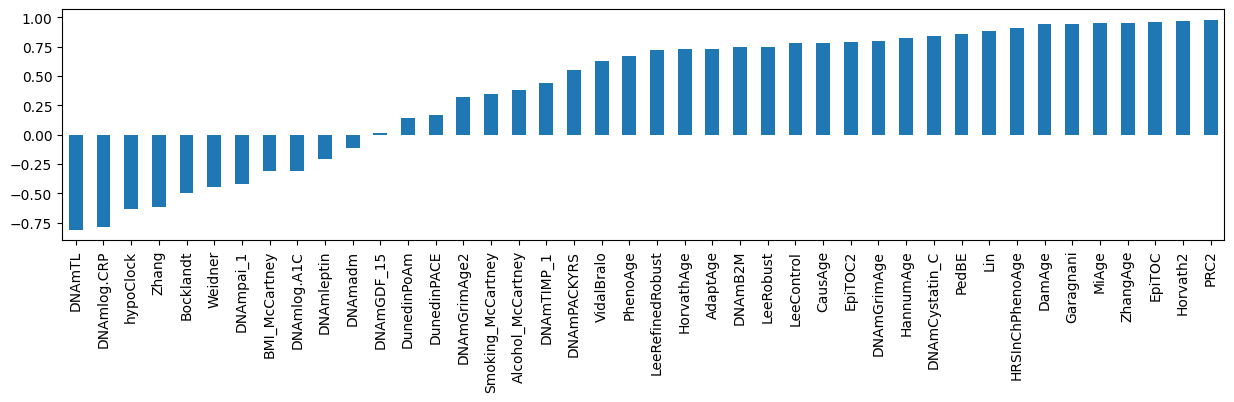

In [182]:
#S.Fig 2 - plotting correlation of various published epigenetic clocks applied to WGBS epidermis

r=pd.read_csv('SupplementFig2/s_clocks.csv',index_col=0)
r.index=r.index.astype(str)
r['age']=[int(cell) for cell in cells]
r['PRC2']=cor['m']
pl=r.corrwith(r['age']).sort_values().round(2).drop('age')
ax=pl.plot(kind='bar',figsize=(15,3));
ax.get_figure().savefig('figures/FigS2_epidermis.eps', dpi=600,bbox_inches='tight',format='eps')

SRR4473855,SRR4473856,SRR4473857,SRR4473858,SRR4473859,SRR4473860,SRR4473861,SRR4473862,

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


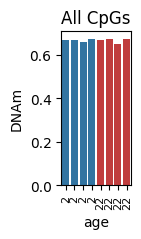

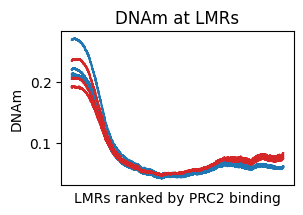

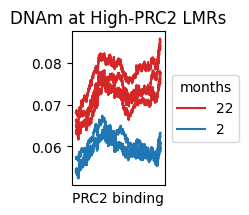

In [217]:
#Fig 2.a - Generating Mouse Liver LMR plots (GSE89274)

cells=['SRR44738'+str(c) for c in range(55,63)]
path='data/meth/l/'
ages=[2,2,2,2,22,22,22,22]
colors=4*['tab:blue']+4*['tab:red']
pl=pwg(cells,path,'age',chrs=19,labels=ages,color=colors,figure='Fig2_a_mouse_wg')
l=pd.read_csv('results/l.csv')
lp=prc(l)
pprc(lp,colors,figure='Fig2_a_mouse_lmr')
lch=pprch(lp,5.6,4.7,labels=ages,legend_title='months',color=4*['tab:blue']+4*['tab:red'],figure='Fig2_a_mouse_prc')

SRR4473855,SRR4473856,SRR4473857,SRR4473858,SRR4473859,SRR4473860,SRR4473861,SRR4473862,SRR4473863,SRR4473864,SRR4473865,SRR4473866,SRR4473867,SRR4473868,SRR4473869,SRR4473870,

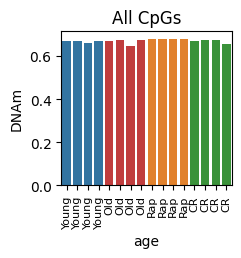

In [218]:
# Fig 4a - Mean methylation of CR mouse liver dataset (GSE89274)
cells=['SRR44738'+str(c) for c in range(55,55+16)]
path='data/meth/l/'
ages=4*['Young']+4*['Old']+4*['Rap']+4*['CR']
pl=pwg(cells,path,'age',chrs=19,labels=ages, color=4*['tab:blue']+4*['tab:red']+4*['tab:orange']+4*['tab:green'],w=2.2,figure='Fig4_a_wg')

In [219]:
l=pd.read_csv('results/l16.csv')
lp=prc(l)
colors=4*['tab:blue']+4*['tab:red']+4*['tab:orange']+4*['tab:green']

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


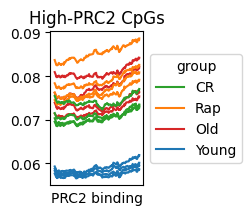

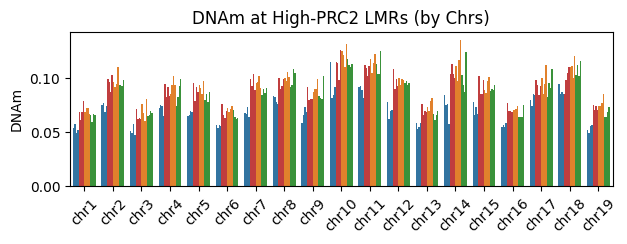

In [13]:
# Fig 4a - PRC2 AgeIndex plot of CR mouse liver dataset  (GSE89274)
figure='Fig4_a_prc_line'
n=5;m=4.8;labels=ages;legend_title='group'
ax=lp.tail(round(10**n)).rolling(round(10**m)).mean().dropna().plot(figsize=(1.2,2),color=colors)
handles, _ = ax.get_legend_handles_labels()    
ax.legend([handles[12],handles[8],handles[4],handles[0]], [labels[12],labels[8],labels[4],labels[0]],title=legend_title,loc='center left', bbox_to_anchor=(1, 0.5))    
ax.set_xticks([])
ax.set_xlabel('PRC2 binding', fontsize=10)  
ax.set_title('High-PRC2 CpGs') 
ax.get_figure().savefig('figures/'+figure+'.eps', dpi=600,bbox_inches='tight',format='eps')
chs(l,cells,3,ages=ages,color=colors,figure='Fig4_a_chr')

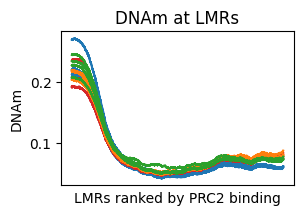

In [221]:
pprc(lp,colors,figure='')

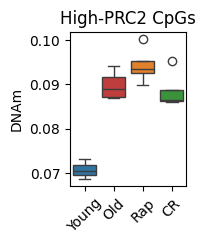

In [222]:
# Fig 4a - Boxplot of top 1000 LMRs of CR mouse liver dataset  (GSE89274)

figure='Fig4_a_prc_box'
lm=l.tail(1000)[cells].mean()
lm.index=ages
fig, ax = plt.subplots(figsize=(1.5,2));
sns.boxplot(x=lm.index,y=lm.values,palette=['tab:blue','tab:red','tab:orange','tab:green'])
ax.set(ylabel='DNAm',title='High-PRC2 CpGs',xlabel='');
plt.xticks(rotation=45);
ax.get_figure().savefig('figures/'+figure+'.eps', dpi=600,bbox_inches='tight',format='eps')

In [97]:
#t-test between old and CR mouse samples for top 1000 PRC2 binding CpGs
o=lm[4:8].values
c=lm[12:15].values
from scipy.stats import ttest_ind
ttest, pval = ttest_ind(c, o, alternative="less")
pval

0.06920086750876078

In [98]:
#The following plots are the PRC2-AgeIndex applied to various cancer datasets from TCGA for Figure 5a

In [17]:
data_path='../data/'

n,t1,t2,

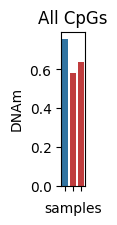

In [18]:
cohort='READ'
samples='samples'
cells=['n','t1','t2']
colors=['tab:blue']+2*['tab:red']
path=data_path+'meth/c/r/' # READ
labels=cells#['MEF']+['D'+str(d) for d in range(1,9)]+['iPS']
pl=pwg(cells,path,samples,labels=3*[''],w=.3,color=colors,figure='Fig5_'+cohort+'_wg')

In [19]:
#f5prc_fig='Fig5_'+cohort+'_prc'
#f5prc_title='DNAm at LMRs - '+cohort

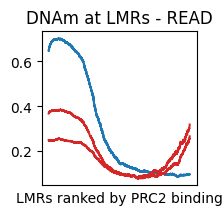

In [22]:
c=pd.read_csv('results/c_r.csv')
lc=prc(c)
pprc(lc,color=colors,w=2,ylabel='',figure='Fig5_'+cohort+'_prc',title='DNAm at LMRs - '+cohort)

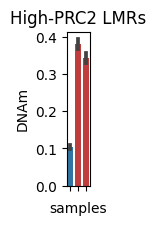

In [23]:
hprc(cohort, colors)

n,t1,t2,

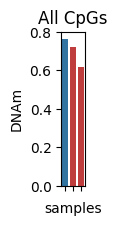

In [25]:
cohort='COAD'
samples='samples'
cells=['n','t1','t2']
colors=['tab:blue']+2*['tab:red']
path=data_path+'meth/c/c/' # COAD
labels=cells#['MEF']+['D'+str(d) for d in range(1,9)]+['iPS']
pl=pwg(cells,path,samples,labels=['','',''],w=.3,color=colors,figure='Fig5_'+cohort+'_wg')

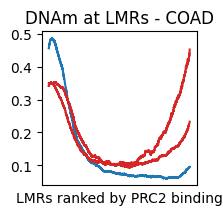

In [26]:
c=pd.read_csv('results/c_c.csv')
lc=prc(c)
pprc(lc,color=colors,w=2,ylabel='',figure='Fig5_'+cohort+'_prc',title='DNAm at LMRs - '+cohort)

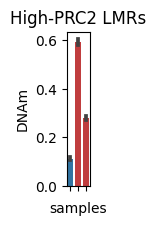

In [27]:
hprc(cohort, colors)

n,t1,t2,t3,t4,

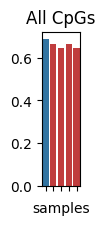

In [28]:
cohort='STAD'
cells=['n','t1','t2','t3','t4']
colors=['tab:blue']+4*['tab:red']
path=data_path+'meth/c/s/' # STAD
labels=cells#['MEF']+['D'+str(d) for d in range(1,9)]+['iPS']
pl=pwg(cells,path,samples,labels=5*[''],w=.5,color=colors,ylabel='',figure='Fig5_'+cohort+'_wg')

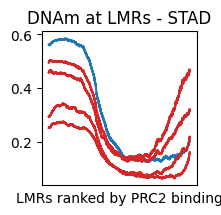

In [29]:
c=pd.read_csv('results/c_s.csv')
lc=prc(c)
pprc(lc,color=colors,w=2,ylabel='',figure='Fig5_'+cohort+'_prc',title='DNAm at LMRs - '+cohort)

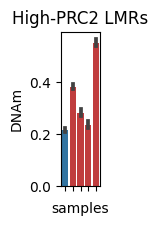

In [30]:
hprc(cohort, colors)

n,t1,t2,t3,t4,

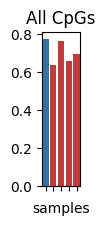

In [31]:
cohort='LUSC'
cells=['n','t1','t2','t3','t4']
colors=['tab:blue']+4*['tab:red']
path=data_path+'meth/c/l/' #LUSC
labels=cells#['MEF']+['D'+str(d) for d in range(1,9)]+['iPS']
pl=pwg(cells,path,samples,labels=5*[''],w=.5,color=colors,ylabel='',figure='Fig5_'+cohort+'_wg')

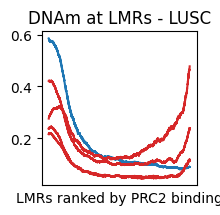

In [32]:
c=pd.read_csv('results/c_lusc.csv')
lc=prc(c)
pprc(lc,color=colors,w=2,ylabel='',figure='Fig5_'+cohort+'_prc',title='DNAm at LMRs - '+cohort)

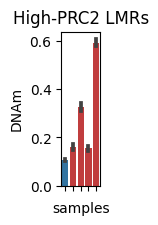

In [33]:
hprc(cohort, colors)

n,t1,t2,t3,t4,t5,

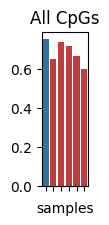

In [34]:
cohort='LUAD'
cells=['n','t1','t2','t3','t4','t5']
colors=['tab:blue']+5*['tab:red']
path=data_path+'meth/c/luad/' #LUAD
labels=cells#['MEF']+['D'+str(d) for d in range(1,9)]+['iPS']
pl=pwg(cells,path,samples,labels=6*[''],w=.6,color=colors,ylabel='',figure='Fig5_'+cohort+'_wg')

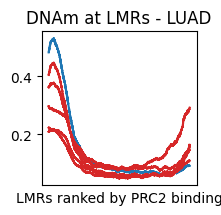

In [35]:
c=pd.read_csv('results/c_luad.csv')
lc=prc(c)
pprc(lc,color=colors,w=2,ylabel='',figure='Fig5_'+cohort+'_prc',title='DNAm at LMRs - '+cohort)

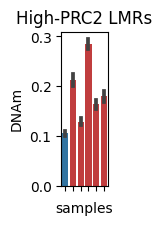

In [36]:
hprc(cohort, colors)

n,t1,t2,t3,t4,t5,

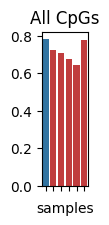

In [37]:
cohort='UCEC'
cells=['n','t1','t2','t3','t4','t5']
colors=['tab:blue']+5*['tab:red']
path=data_path+'meth/c/u/' #UCEC
labels=cells#['MEF']+['D'+str(d) for d in range(1,9)]+['iPS']
pl=pwg(cells,path,samples,labels=6*[''],w=.6,color=colors,ylabel='',figure='Fig5_'+cohort+'_wg')

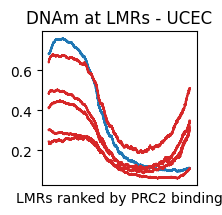

In [38]:
c=pd.read_csv('results/c_u.csv')
lc=prc(c)
pprc(lc,color=colors,w=2,ylabel='',figure='Fig5_'+cohort+'_prc',title='DNAm at LMRs - '+cohort)

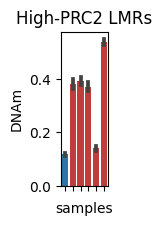

In [39]:
hprc(cohort, colors)

n,t1,t2,t3,t4,t5,t6,

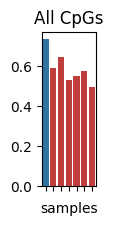

In [46]:
cohort='BLCA'
cells=['n','t1','t2','t3','t4','t5','t6']
colors=['tab:blue']+6*['tab:red']
path=data_path+'meth/c/blca/' 
labels=cells#['MEF']+['D'+str(d) for d in range(1,9)]+['iPS']
pl=pwg(cells,path,samples,labels=7*[''],w=.7,color=colors,ylabel='',figure='Fig5_'+cohort+'_wg')

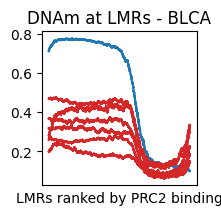

In [47]:
c=pd.read_csv('results/c_blca.csv')
lc=prc(c)
pprc(lc,color=colors,w=2,ylabel='',figure='Fig5_'+cohort+'_prc',title='DNAm at LMRs - '+cohort)

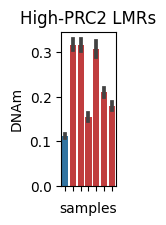

In [42]:
hprc(cohort, colors)

n,t1,t2,t3,t4,t5,

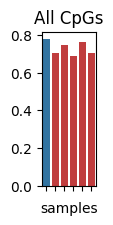

In [43]:
cohort='BRCA'
cells=['n','t1','t2','t3','t4','t5']
colors=['tab:blue']+6*['tab:red']
path=data_path+'meth/c/brca/'
labels=cells#['MEF']+['D'+str(d) for d in range(1,9)]+['iPS']
pl=pwg(cells,path,samples,labels=6*[''],w=.7,color=colors,ylabel='',figure='Fig5_'+cohort+'_wg')

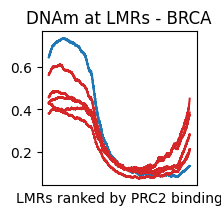

In [44]:
c=pd.read_csv('results/c_brca.csv')
lc=prc(c)
pprc(lc,color=colors,w=2,ylabel='',figure='Fig5_'+cohort+'_prc',title='DNAm at LMRs - '+cohort)

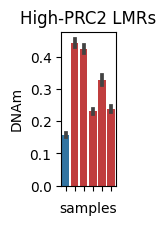

In [45]:
hprc(cohort, colors)

GSM2877239,GSM2877242,GSM2877183,GSM2877177,GSM2877184,GSM2877238,

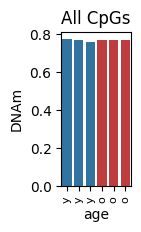

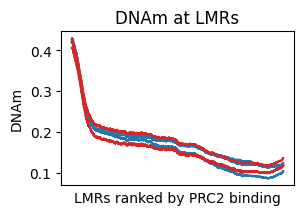

In [208]:
# Fig 5b - PRC2-AgeIndex applied to brain oligodendrocytes (GSE107729)
y=['GSM2877239','GSM2877242','GSM2877183']
o=['GSM2877177','GSM2877184','GSM2877238']
cells=y+o
path='data/meth/b/'
labels=3*['y']+3*['o']
colors=3*['tab:blue']+3*['tab:red']
pl=pwg(cells,path,'age',labels=labels,color=colors,figure='Fig5_b_wg')
f=pd.read_csv('results/b.csv')
fp=prc(f)
dg=pprc(fp,colors,figure='Fig5_b_lmr')

4,7,10,31,33,

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


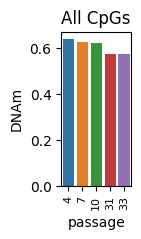

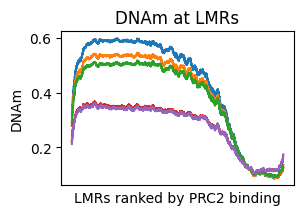

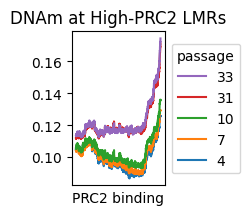

In [210]:
# Fig 5c - PRC2-AgeIndex applied to passaged fibroblast data (GSE79798)
cells=['4','7','10','31','33']
path='data/meth/f/'
pl=pwg(cells,path,'passage',figure='Fig5_c_wg')
f=pd.read_csv('results/fv.csv')
fp=prc(f)
dg=pprc(fp,figure='Fig5_c_lmr')
dg=pprch(fp,6,5,legend_title='passage',figure='Fig5_c_prc')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


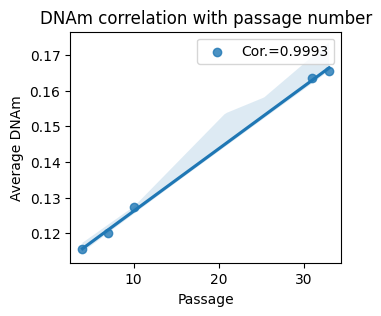

In [211]:
# Fig 5c - Correlation of top 1000 LMR methylation and passage

p=pd.DataFrame(f.tail(1000)[cells].mean())
p['Passage']=[4,7,10,31,33]
figure='Fig5_c_corr'
p.columns=['Average DNAm','Passage']#,'Condition','Individual']
fig, ax = plt.subplots(figsize=(3.5,3))
ax=sns.regplot(data=p,x='Passage',y='Average DNAm',label='Cor.='+str(p.corr().values[0,1].round(4)))
ax.legend(loc="best")    
ax.set(title='DNAm correlation with passage number');
ax.get_figure().savefig('figures/'+figure+'.eps', dpi=600,bbox_inches='tight',format='eps')

In [212]:
#Correlation of passaging and methylation of top 1000 LMRs in passaged fibroblasts
cor=pd.DataFrame(f[cells].tail(1000).mean(),columns=['m'])
cor['age']=[int(cell) for cell in cells]
cor.corrwith(cor['age']).m.round(4)

0.9993

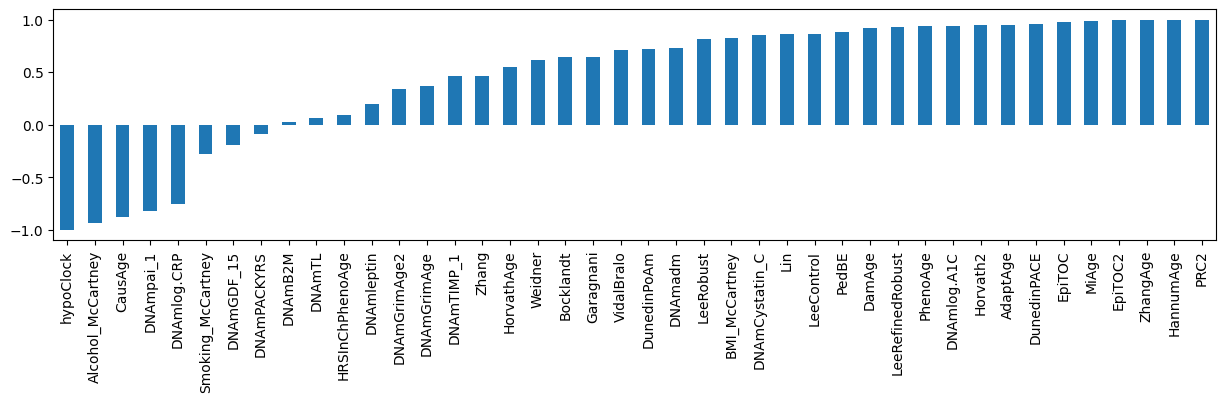

In [213]:
#S.Fig 2 - plotting correlation of various published epigenetic clocks applied to WGBS passaged fibroblast data

r=pd.read_csv('SupplementFig2/f_clocks.csv',index_col=0)
r.index=r.index.astype(str)
r['age']=[int(cell) for cell in cells]
r['PRC2']=cor['m'].values
pl=r.corrwith(r['age']).sort_values().round(2).drop('age')
ax=pl.plot(kind='bar',figsize=(15,3));
ax.get_figure().savefig('figures/FigS2_fibroblast.eps', dpi=600,bbox_inches='tight',format='eps')

NEO2_P2_meth,NEO2_P5_meth,NEO2_P8_meth,

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


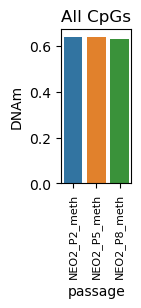

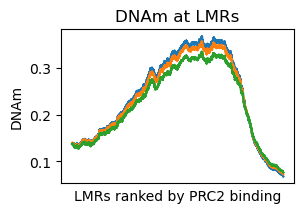

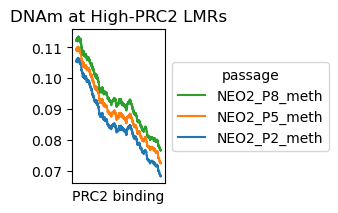

In [16]:
# Fig 6a - PRC2-AgeIndex applied to neonatal fibroblast data ordered by neonatal fibroblast EZH2 binding (GSE253987)
cells=["NEO2_P2_meth","NEO2_P5_meth","NEO2_P8_meth"]
path='data/meth/NeoFib/'
pl=pwg(cells,path,'passage',figure='f6_a_Neo_wg')
neo=pd.read_csv('results/NEOP2s_methBWs_NEOMergeP2_FE.csv')
fp=prc(neo)
dg=pprc(fp,figure='f6_a_Neo_lmr')
dg=pprchz(fp,6,5,legend_title='passage',figure='f6_a_Neo_prc')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


   NEO2_P2_meth  NEO2_P5_meth  NEO2_P8_meth
0         0.109         0.126         0.102
1         0.193         0.180         0.217
2         0.291         0.238         0.264
3         0.236         0.227         0.378
4         0.191         0.173         0.170
5         0.043         0.083         0.064
6         0.049         0.068         0.061
7         0.252         0.308         0.310
8         0.048         0.053         0.054
9         0.135         0.182         0.145
                     0
NEO2_P2_meth  0.080600
NEO2_P5_meth  0.084882
NEO2_P8_meth  0.089189


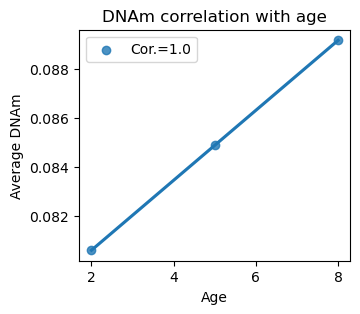

In [24]:
# Fig 6a - neonatal fibroblast mean correlation plot top 1000 LMRs sorted by neonatal fibroblast EZH2 binding (GSE253987)

p= pd.read_csv('results/NEOP2s_methBWs_NEOMergeP2_FE.csv', usecols=["NEO2_P2_meth","NEO2_P5_meth","NEO2_P8_meth"]) 

cells=["NEO2_P2_meth","NEO2_P5_meth","NEO2_P8_meth"]
#note, the headers were manually edited to 0, 18, 25 etc since R puts an X at the beginning of each colname

print(p.head(10))

p=p.tail(1000)

p=pd.DataFrame(p[cells].mean())

print(p)

p['Passage']=[2,5,8]
figure='Fig6a_NEO_corr_top1000'
p.columns=['Average DNAm','Age']#,'Condition','Individual']
fig, ax = plt.subplots(figsize=(3.5,3))
ax=sns.regplot(data=p,x='Age',y='Average DNAm',label='Cor.='+str(p.corr().values[0,1].round(4)),ci=None)
ax.legend(loc="best")    
ax.set(title='DNAm correlation with age');
ax.get_figure().savefig('figures/'+figure+'.eps', dpi=600,bbox_inches='tight',format='eps')

OLD3_P2_meth,OLD3_P5_meth,OLD3_P8_meth,

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


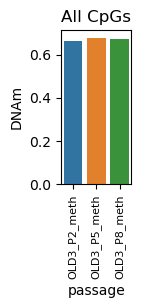

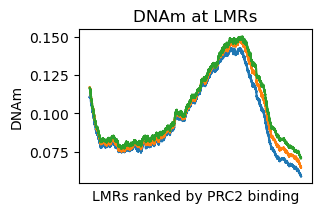

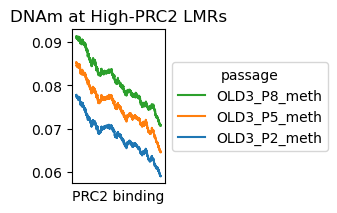

In [17]:
# Fig 6a - PRC2-AgeIndex applied to old fibroblast data ordered by old fibroblast EZH2 binding (GSE253987)
cells=["OLD3_P2_meth","OLD3_P5_meth","OLD3_P8_meth"]
path='data/meth/OldFib/'
pl=pwg(cells,path,'passage',figure='f6_a_Old_wg')
old=pd.read_csv('results/OLDP2s_methBWs_OLDMergeP2_FE.csv')
fp=prc(old)
dg=pprc(fp,figure='f6_a_Old_lmr')
dg=pprchz(fp,6,5,legend_title='passage',figure='f6_a_Old_prc')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


   OLD3_P2_meth  OLD3_P5_meth  OLD3_P8_meth
0         0.069         0.094         0.169
1         0.150         0.176         0.094
2         0.088         0.063         0.059
3         0.174         0.291         0.158
4         0.156         0.191         0.260
5         0.060         0.033         0.057
6         0.340         0.446         0.387
7         0.149         0.097         0.079
8         0.034         0.074         0.063
9         0.319         0.467         0.411
                     0
OLD3_P2_meth  0.071200
OLD3_P5_meth  0.079420
OLD3_P8_meth  0.085888


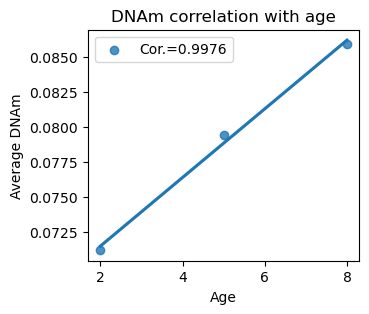

In [25]:
# Fig 6a - old fibroblast mean correlation plot top 1000 LMRs sorted by old fibroblast EZH2 binding (GSE253987)

p= pd.read_csv('results/OLDP2s_methBWs_OLDMergeP2_FE.csv', usecols=["OLD3_P2_meth","OLD3_P5_meth","OLD3_P8_meth"]) 

cells=["OLD3_P2_meth","OLD3_P5_meth","OLD3_P8_meth"]
#note, the headers were manually edited to 0, 18, 25 etc since R puts an X at the beginning of each colname

print(p.head(10))

p=p.tail(1000)

p=pd.DataFrame(p[cells].mean())

print(p)

p['Passage']=[2,5,8]
figure='Fig6a_OLD_corr_top1000'
p.columns=['Average DNAm','Age']#,'Condition','Individual']
fig, ax = plt.subplots(figsize=(3.5,3))
ax=sns.regplot(data=p,x='Age',y='Average DNAm',label='Cor.='+str(p.corr().values[0,1].round(4)),ci=None)
ax.legend(loc="best")    
ax.set(title='DNAm correlation with age');
ax.get_figure().savefig('figures/'+figure+'.eps', dpi=600,bbox_inches='tight', format='eps')

0,18,25,82,86,103,

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


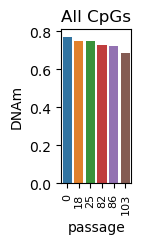

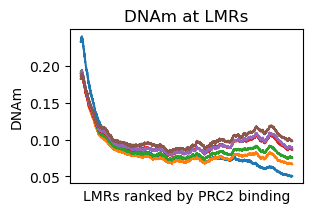

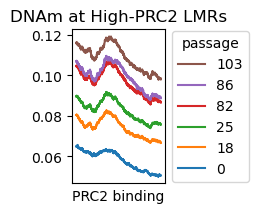

In [19]:
# Fig 6a - PRC2-AgeIndex applied to old fibroblast data ordered by old fibroblast EZH2 binding (GSE79798, GSE31263 & GSE253773)
cells=['0','18','25','82','86','103']
path='data/meth/t/'
pl=pwg(cells,path,'passage',figure='f6_a_t_wg')
old=pd.read_csv('results/t_cell_lmrs_CD4pooled_prc2_ENCinp_FE_meth.csv')
fp=prc(old)
dg=pprc(fp,figure='f6_a_t_lmr')
dg=pprchz(fp,6,5,legend_title='passage',figure='f6_a_t_prc')

       0     18     25     82     86    103
0  0.000  0.149  0.091  0.151  0.097  0.117
1  0.026  0.025  0.032  0.039  0.026  0.000
2  0.077  0.058  0.081  0.076  0.107  0.047
3  0.012  0.007  0.009  0.013  0.022  0.000
4  0.305  0.281  0.167  0.174  0.134  0.119
5  0.114  0.052  0.094  0.108  0.127  0.115
6  0.094  0.070  0.100  0.146  0.085  0.200
7  0.076  0.082  0.089  0.056  0.099  0.087
8  0.154  0.262  0.333  0.475  0.455  0.560
9  0.313  0.433  0.491  0.465  0.442  0.498
            0
0    0.063566
18   0.080754
25   0.090576
82   0.103830
86   0.105749
103  0.114460


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


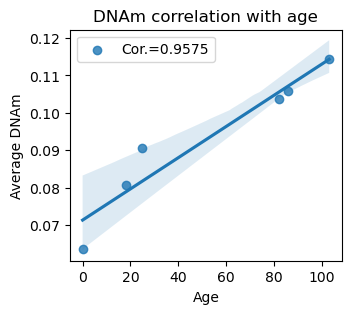

In [26]:
# Fig 6a - T-cell mean correlation plot top 1000 LMRs sorted by T-cell EZH2 binding (GSE79798, GSE31263 & GSE253773)

p= pd.read_csv('results/t_cell_lmrs_CD4pooled_prc2_ENCinp_FE_meth.csv', usecols=['0','18','25','82','86','103']) 

cells=['0','18','25','82','86','103']
#note, the headers were manually edited to 0, 18, 25 etc since R puts an X at the beginning of each colname

print(p.head(10))

p=p.tail(1000)

p=pd.DataFrame(p[cells].mean())

print(p)

p['Age']=[0,18,25,82,86,103]
figure='Fig6a_Tcell_corr_top1000CD4'
p.columns=['Average DNAm','Age']#,'Condition','Individual']
fig, ax = plt.subplots(figsize=(3.5,3))
ax=sns.regplot(data=p,x='Age',y='Average DNAm',label='Cor.='+str(p.corr().values[0,1].round(4)))
ax.legend(loc="best")    
ax.set(title='DNAm correlation with age');
ax.get_figure().savefig('figures/'+figure+'.eps', dpi=600,bbox_inches='tight',format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


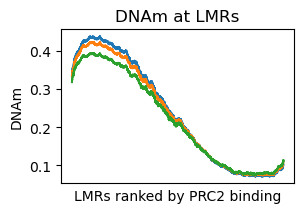

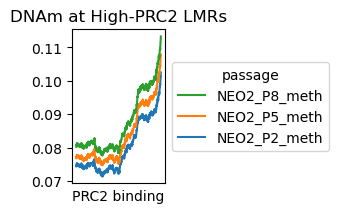

In [21]:
# Fig 6b - PRC2-AgeIndex applied to neonatal fibroblast data ordered by neonatal fibroblast EZH2 binding (GSE253985)
cells=["NEO2_P2_meth","NEO2_P5_meth","NEO2_P8_meth"]
path='data/meth/NeoFib/'

neo=pd.read_csv('results/NEOP2s_methBWs_hESCord_FE.csv')
fp=prc(neo)
dg=pprc(fp,figure='f6_b_Neo_lmr')
dg=pprchz(fp,6,5,legend_title='passage',figure='f6_b_Neo_prc')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


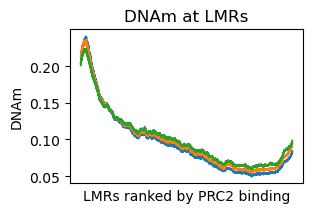

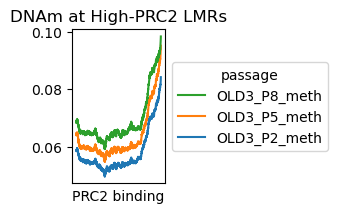

In [22]:
# Fig 6b - PRC2-AgeIndex applied to old fibroblast data ordered by old fibroblast EZH2 binding (GSE253985)
cells=["OLD3_P2_meth","OLD3_P5_meth","OLD3_P8_meth"]
path='data/meth/OldFib/'

old=pd.read_csv('results/OLDP2s_methBWs_hESCord_FE.csv')
fp=prc(old)
dg=pprc(fp,figure='f6_b_Old_lmr')
dg=pprch(fp,6,5,legend_title='passage',figure='f6_b_Old_prc')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


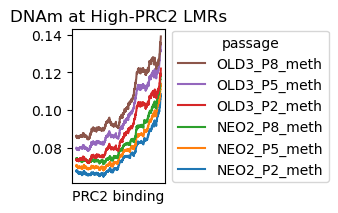

In [23]:
# Fig 6b - PRC2-AgeIndex applied to old fibroblast data ordered by old fibroblast EZH2 binding (GSE253985)
cells=["NEO2_P2_meth","NEO2_P5_meth","NEO2_P8_meth","OLD3_P2_meth","OLD3_P5_meth","OLD3_P8_meth"]
path='data/meth/Neo&OldFib/'

old=pd.read_csv('results/Neo&Old_methBWs_hESCord_FE.csv')
fp=prc(old)

dg=pprchz(fp,6,5,legend_title='passage',figure='f6_c_NeoOld_prc')